### Intro

Chiamo "sistema" una rete di Vogels & Abbott avente determinati parametri. Ogni sistema ha un certo numero (in questo caso 10) di realizzazioni che corrispondono alle realizzazioni delle matrici di connessione e dei valori di inizializzazione del potenziale di membrana. 

La simulazione e' stata svolta in maniera parallela per 2000 sistemi indipendenti, per un totale di 2 milioni di neuroni.

Per ciascuna realizzazione vengono estratte certe quantita', come l'attivita' media e il coefficiente di variazione dell'ISI.

La simulazione e' stata svolta in 28 minuti.

In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("./style.mplstyle")

import seaborn as sns;sns.set()

df = pd.read_csv("spinnaker_results_hugespan.csv")

mask = (df['pop'] == 'exc')
df = df.loc[mask]

df.exc_conn_p *= 100
df.inh_conn_p *= 100

print(f"Number of simulated systems:{len(np.unique(df.sys_id))}")
print(f"Excitatory connectivities are:\n{np.unique(df.exc_conn_p)}")
display(df.head())

Number of simulated systems:2000
Excitatory connectivities are:
[ 1.5         2.26315789  3.02631579  3.78947368  4.55263158  5.31578947
  6.07894737  6.84210526  7.60526316  8.36842105  9.13157895  9.89473684
 10.65789474 11.42105263 12.18421053 12.94736842 13.71052632 14.47368421
 15.23684211 16.        ]


,Unnamed: 0,sys_id,func,pop,extraction,timestep,time_scale_factor,duration,min_delay,neurons_per_core,run_time,lunchbox_id,n_neurons,exc_conn_p,inh_conn_p,synaptic_delay
0,0,341152-140555111243632,avg_activity,exc,0.465789,0.8,50,1000,1.6,250,348.152816,341152,1000,1.500000,2.0,2
2,2,341152-140555111243632,avg_isi_cv,exc,NaN,0.8,50,1000,1.6,250,348.152816,341152,1000,1.500000,2.0,2
4,4,341152-140557165632288,avg_activity,exc,0.714474,0.8,50,1000,1.6,250,348.152816,341152,1000,2.263158,2.0,2
6,6,341152-140557165632288,avg_isi_cv,exc,NaN,0.8,50,1000,1.6,250,348.152816,341152,1000,2.263158,2.0,2
8,8,341152-140557165124480,avg_activity,exc,0.850000,0.8,50,1000,1.6,250,348.152816,341152,1000,3.026316,2.0,2


A look at the execution times

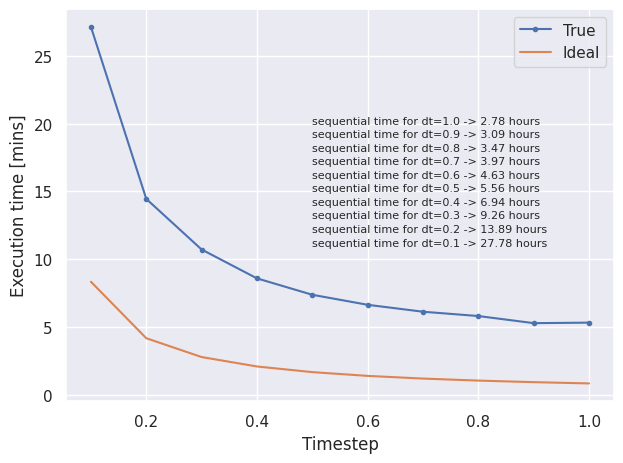

In [28]:
subdf = df.groupby('timestep')[['timestep', 'run_time', 'duration', 'time_scale_factor']].mean()
plt.plot(subdf.timestep, subdf.run_time/60, marker=".", label="True")
plt.plot(subdf.timestep, (subdf.duration*1e-3)*subdf.time_scale_factor/subdf.timestep/60, label="Ideal")
plt.xlabel('Timestep')
plt.ylabel("Execution time [mins]")
# plt.yscale("log")
# plt.xscale('log')
sequential_time = 0

for dt in df.timestep.unique():
    subdf = df[df.timestep == dt].groupby('sys_id')
    time = (subdf.duration.mean() * subdf.time_scale_factor.mean())*1e-3/dt
    number_of_systems = len(subdf.sys_id.unique())
    plt.annotate(f"sequential time for dt={dt} -> {number_of_systems*time.mean()/60/60 :.2f} hours", (0.5, 10 + 10*dt), size=8)
plt.legend()

### Average activity

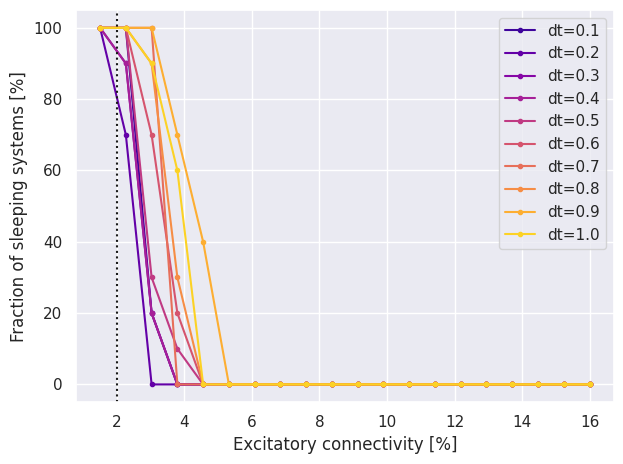

In [29]:
timesteps_to_plot = np.sort(df.timestep.unique()) #[0.1, 0.2, 0.4, 0.6, 0.8, 1.0] #

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    submask = (df.timestep == dt)*(df.func == 'avg_activity')
    subdf = df[submask].copy()
    subdf['is_asleep'] = (subdf.extraction.values < 2.0).astype(int)
    grouped = subdf.groupby('exc_conn_p')[['exc_conn_p', 'extraction', 'is_asleep']].mean()

    plt.plot(grouped.exc_conn_p, grouped.is_asleep*100,  marker=".", label=f"dt={dt}", color=c)

plt.axvline(2, color="k", ls=":")
plt.ylabel('Fraction of sleeping systems [%]')
plt.xlabel('Excitatory connectivity [%]')
plt.legend()

La figura mostra il numero di realizzazioni che non vengono attivate dallo stimolo talamico.
A parita' di connettivita' eccitatoria, i sistemi con un passo di integrazione piu' grande tendono ad essere meno attivabili, mostrando un numero piu' alto di realizzazioni inattive.

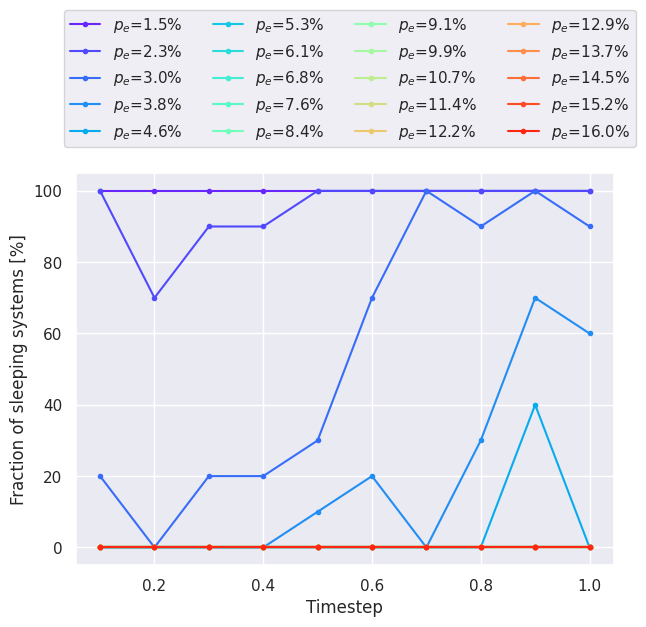

In [30]:
pexc_to_plot = np.sort(np.unique(df.exc_conn_p))
fig, ax = plt.subplots()
colors = sns.color_palette('rainbow', len(pexc_to_plot))
for pexc ,c in zip(pexc_to_plot, colors):
    submask = (df.exc_conn_p == pexc)*(df.func == 'avg_activity')
    subdf = df[submask].copy()
    subdf['is_asleep'] = (subdf.extraction.values < 2.0).astype(int)
    grouped = subdf.groupby('timestep')[['timestep', 'extraction', 'is_asleep']].mean()

    plt.plot(grouped.timestep, grouped.is_asleep*100,  marker=".", label=f"$p_e$={pexc:.1f}%", color=c)

plt.ylabel('Fraction of sleeping systems [%]')
plt.xlabel('Timestep')
fig.legend(ncols=4, loc='lower left', bbox_to_anchor=(0.1,1))

La stessa cosa in funzione del timestep. Fissata la connettivita, aumentando il timestep aumenta il numero di samples montecarlo che non vengono attivati.

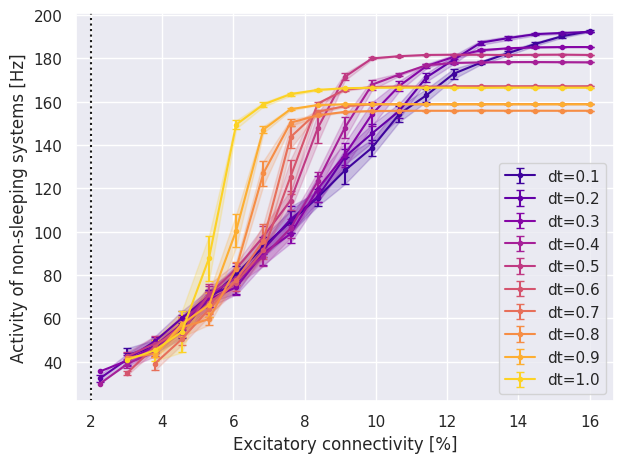

In [31]:
from sklearn.linear_model import LinearRegression
timesteps_to_plot = np.sort(df.timestep.unique())

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    submask = (df.timestep == dt)&(df.func == 'avg_activity')&(df.extraction > 2 )
    subdf = df[submask]
    avgs = subdf.groupby('exc_conn_p')[['exc_conn_p', 'extraction']].mean()
    stds = subdf.groupby('exc_conn_p')[['exc_conn_p', 'extraction']].std()

    model = LinearRegression()
    model.fit(subdf.exc_conn_p.values.reshape(-1,1), subdf.extraction.values.reshape(-1,1))
    xx = np.linspace(np.min(subdf.exc_conn_p), np.max(subdf.exc_conn_p), 2)
    # plt.plot(xx, model.predict(xx[:, None]), color=c)

    plt.errorbar(avgs.exc_conn_p, avgs.extraction, 0.5*stds.extraction,  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(avgs.exc_conn_p, avgs.extraction - 0.5*stds.extraction, avgs.extraction + 0.5*stds.extraction, color=c, alpha=0.2)

plt.axvline(2, color="k", ls=":")
plt.ylabel('Activity of non-sleeping systems [Hz]')
plt.xlabel('Excitatory connectivity [%]')
plt.legend()

Attivita' media delle realizzazioni attive (esclusi quindi quelle inattive, che hanno attivita' media 0). Chiaramente aumentando la connettivita' della sottorete eccitatoria aumenta l'attivita'. Per ogni valore del time step esiste un valore di connettivita' $p_{sat}$ per cui i sistemi saturano. Aumentando la precisione temporale il valore di $p_{sat}$ aumenta, quindi presumibilmente la saturazione e' un effetto dovuto all'errore di troncamento globale del sistema di ODEs. Ipotesi: Trattandosi di equazioni di primo ordine e' ragionevole pensare che l'errore di troncamento globale faccia in modo che il singolo neurone abbia all'atto pratico un tempo caratteristico $ \tau _{eff} < \tau_m $. Dal momento che il neurone si evolve piu' rapidamente spara prima, che porta a un processo a cascata. 

Il valore di saturazione non corrispone alla frequenza massima ammissibile (fortunatamente).

Stima teorica $p_{sat} (dt)$ ?

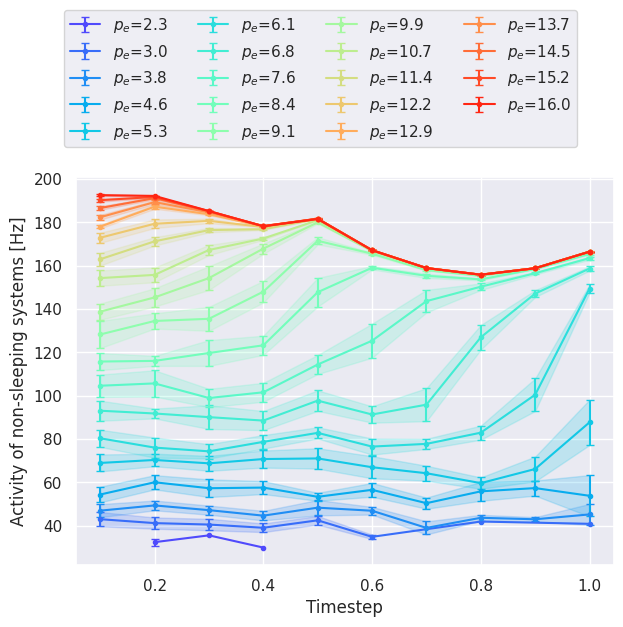

In [32]:
from sklearn.linear_model import LinearRegression
pexc_to_plot = np.sort(df.exc_conn_p.unique())

colors = sns.color_palette('rainbow', len(pexc_to_plot))
fig, ax = plt.subplots()
for pexc, c in zip(pexc_to_plot, colors):
    submask = (df.exc_conn_p == pexc)&(df.func == 'avg_activity')&(df.extraction > 2 )
    subdf = df[submask]
    if len(subdf) == 0:
        continue
    avgs = subdf.groupby('timestep')[['timestep', 'extraction']].mean()
    stds = subdf.groupby('timestep')[['timestep', 'extraction']].std()

    model = LinearRegression()
    model.fit(subdf.timestep.values.reshape(-1,1), subdf.extraction.values.reshape(-1,1))
    xx = np.linspace(np.min(subdf.timestep), np.max(subdf.timestep), 2)
    # plt.plot(xx, model.predict(xx[:, None]), color=c)

    plt.errorbar(avgs.timestep, avgs.extraction, 0.5*stds.extraction,  marker=".", ls="-",   label=f"$p_e$={pexc:.1f}", color=c)
    plt.fill_between(avgs.timestep, avgs.extraction - 0.5*stds.extraction, avgs.extraction + 0.5*stds.extraction, color=c, alpha=0.2)

plt.ylabel('Activity of non-sleeping systems [Hz]')
plt.xlabel('Timestep')
fig.legend(loc='lower left', bbox_to_anchor=(0.1,1), ncols=4)

Stessa cosa vista al contrario: $\langle A(t) \rangle$ in funzione del timestep per ogni connettivita'. A bassa connettivita' un timestep piu' alto e' piu' coerente con il 'valore vero' di $\langle A(t) \rangle$, quello per $dt \rightarrow 0$.

### ISI CV

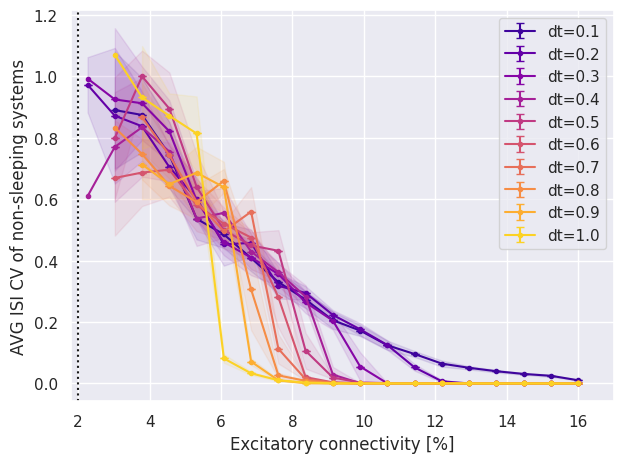

In [33]:
from sklearn.linear_model import LinearRegression
timesteps_to_plot = np.sort(df.timestep.unique())

colors = sns.color_palette('plasma', len(timesteps_to_plot))
for dt ,c in zip(timesteps_to_plot, colors):
    submask = (df.timestep == dt)&(df.func == 'avg_isi_cv')
    subdf = df[submask].copy()
    subdf = subdf.dropna()
    avgs = subdf.groupby('exc_conn_p')[['exc_conn_p', 'extraction']].mean()
    stds = subdf.groupby('exc_conn_p')[['exc_conn_p', 'extraction']].std()

    model = LinearRegression()
    model.fit(subdf.exc_conn_p.values.reshape(-1,1), subdf.extraction.values.reshape(-1,1))
    xx = np.linspace(np.min(subdf.exc_conn_p), np.max(subdf.exc_conn_p), 2)
    # plt.plot(xx, model.predict(xx[:, None]), color=c)

    plt.errorbar(avgs.exc_conn_p, avgs.extraction, .0*stds.extraction,  marker=".", ls="-",   label=f"dt={dt}", color=c)
    plt.fill_between(avgs.exc_conn_p, avgs.extraction - 0.5*stds.extraction, avgs.extraction + 0.5*stds.extraction, color=c, alpha=0.1)

plt.axvline(2, color="k", ls=":")
plt.xlim(1.8, 17)
plt.ylabel('AVG ISI CV of non-sleeping systems')
plt.xlabel('Excitatory connectivity [%]')
plt.legend()

L' ISI CV decresce al decrescere della connettivita'. Reti troppo connesse mostrano un firing piu' regolare rispetto al 'valore vero'. Una cosa curiosa: prima di discendere ad un firing forzosamente regolare le reti mostrano un picco di irregolarita'. Questo picco avviene subito prima che la rete saturi ad un regime di alta attivita'. 

Ad ogni modo, e' piu corretto dire che il picco in $CV$ si verifichi per una certa connettivita' di saturazione (presumibilmente la stessa $p_{sat}$ di prima) perche' $\langle A \rangle (p_{sat})$ non e' uguale per ogni dt. 

### Activity vs CV

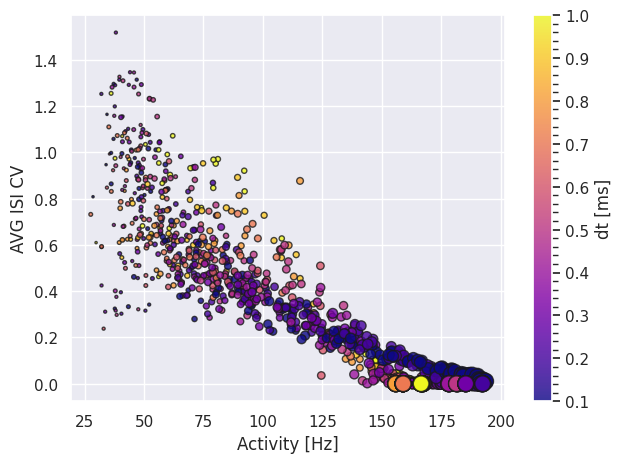

In [34]:
pexc_to_plot = np.sort(np.unique(df.exc_conn_p))
fig, ax = plt.subplots()

for pexc in pexc_to_plot:
    subdf = df[df.exc_conn_p == pexc]
    mappable = ax.scatter(subdf[subdf.func =='avg_activity'].extraction, subdf[subdf.func=='avg_isi_cv'].extraction, 
                c=subdf[subdf.func=='avg_activity'].timestep,
                s=0.5*(pexc)**2,
                edgecolor="k",
                alpha=0.8,
                cmap="plasma",label=f"$p_e$={pexc:.1f}%")
fig.colorbar(mappable, label="dt [ms]")
ax.set_xlabel("Activity [Hz]");
ax.set_ylabel("AVG ISI CV");

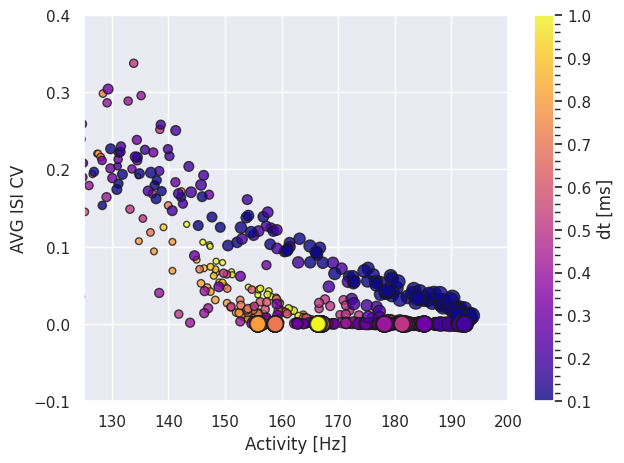

In [35]:
ax.set_xlim(125, 200)
ax.set_ylim(-0.1, 0.4)
display(fig)